
----
# Plot the New England States

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../../load_magic/dataframes.py
%run ../../load_magic/storage.py
s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
dir()

['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['In', 'Out', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'csv', 'example_iterrows', 'exit', 'filepath_regex', 'get_column_descriptions', 'get_ipython', 'get_max_rsquared_adj', 'get_page_tables', 'io', 'math', 'os', 'pd', 'pickle', 'plt', 'quit', 're', 's', 'sm', 'sns', 'stats', 'sys', 'url_regex']

In [3]:

states_stats_df = s.load_object('states_stats_df')
mask_series = (states_stats_df.BoEA_Region == 'New England')
states_list = states_stats_df[mask_series].State_Abbreviation.tolist()
states_list

['CT', 'ME', 'MA', 'NH', 'RI', 'VT']

In [4]:

from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
from matplotlib.dates import date2num
from matplotlib import dates as mdates
from matplotlib import ticker

def plot_rt(result_df, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result_df['ML'].index.get_level_values('date')
    start_date = index[0] - pd.Timedelta(days=1)
    values = result_df['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result_df['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result_df['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=start_date,
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=-1)
    
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(start_date, result_df.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\Most_Recent_Rt_among_the_New_England_States.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\Most_Recent_Rt_among_the_New_England_States.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\Most_Recent_Rt_among_the_New_England_States.svg


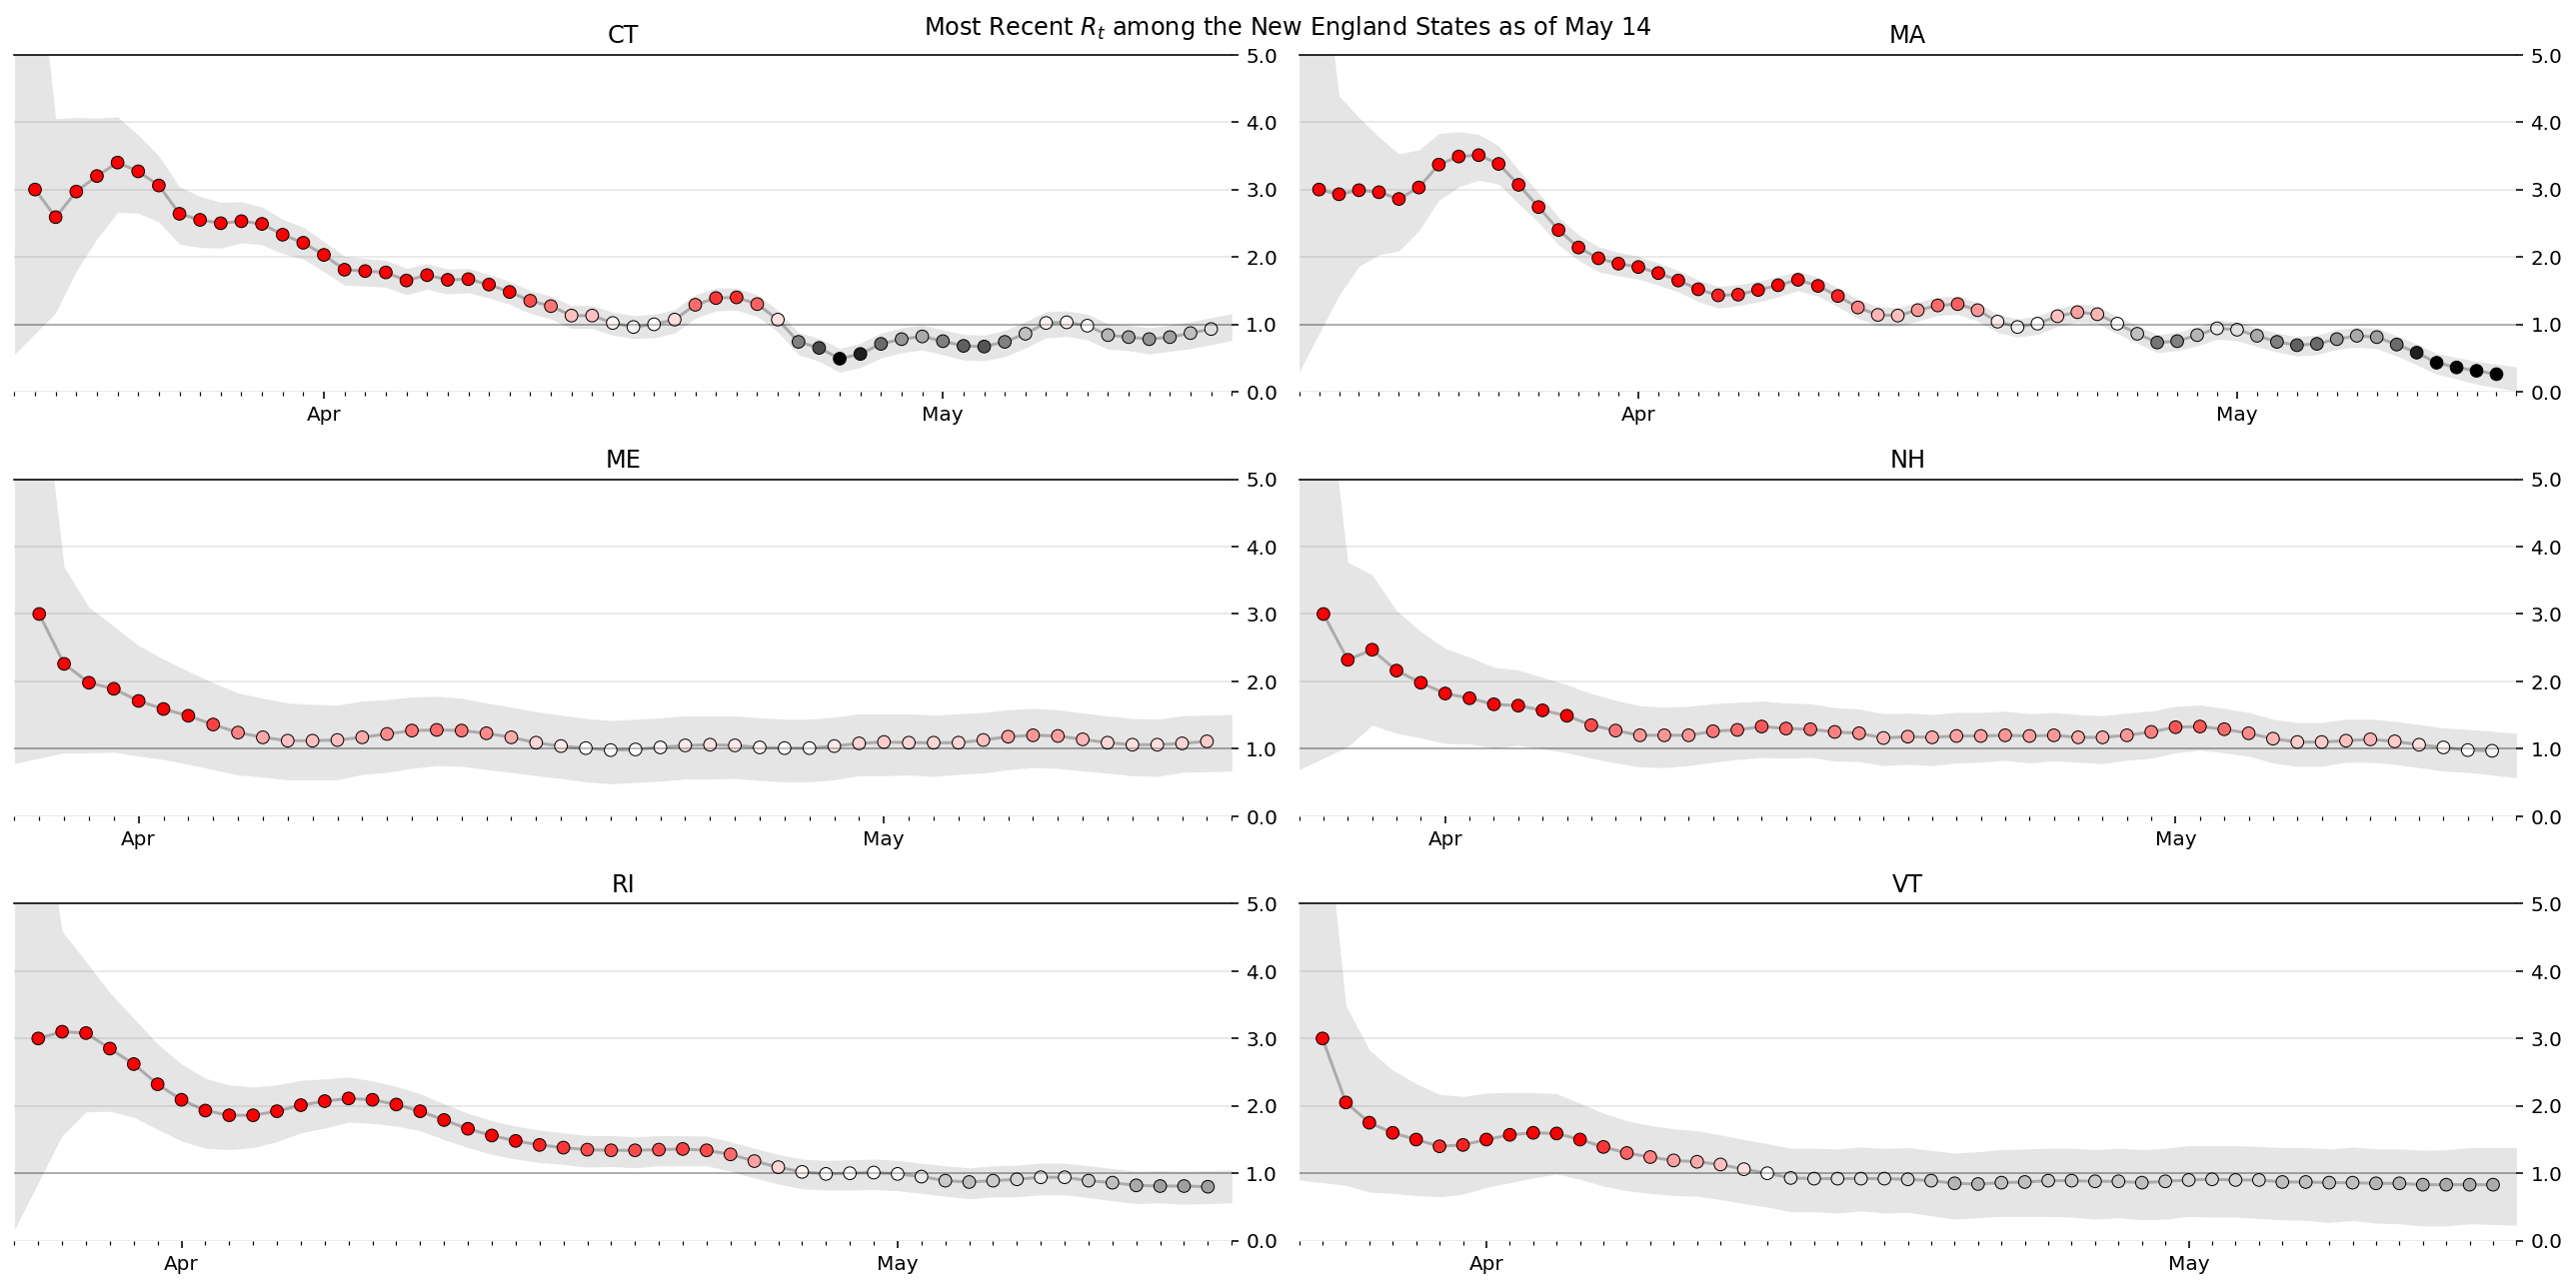

In [23]:

%run ../../load_magic/charts.py
final_results = s.load_object('final_results')
mask_series = final_results.index.get_level_values('state').isin(states_list)
states_list = final_results[mask_series].index.get_level_values('state').unique().tolist()
ncols = int(np.floor(np.sqrt(len(states_list))))
if ncols > 4:
    ncols = 4
nrows = int(np.ceil(len(states_list) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 9))

states_groupby = final_results[mask_series].groupby('state')
for i, (state_name, result_series) in enumerate(states_groupby):
    plot_rt(result_series, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')
offset = len(states_list) - (ncols*nrows) - 1
if abs(offset) > 1:
    for i in range(offset, 0):
        axes_tuple = axes[nrows-1, i].axis('off')
fig.suptitle('Most Recent $R_t$ among the New England States as of {}'.format(final_results.index[-1][1].strftime('%B %d')),
             x=0.5, y=0.99)
save_fig_as_various(fig, 'Most_Recent_Rt_among_the_New_England_States', verbose=True)

### Standings

In [6]:

# As of 4/12
no_lockdown = [
    'North Dakota', 'ND',
    'South Dakota', 'SD',
    'Nebraska', 'NB',
    'Iowa', 'IA',
    'Arkansas','AR'
]
partial_lockdown = [
    'Utah', 'UT',
    'Wyoming', 'WY',
    'Oklahoma', 'OK',
    'Massachusetts', 'MA'
]
FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FULL_COLOR = [.7, .7, .7]
NONE_COLOR = [179/255, 35/255, 14/255]
PARTIAL_COLOR = [.5, .5, .5]
ERROR_BAR_COLOR = [.3, .3, .3]

In [7]:

from matplotlib.patches import Patch

filtered = final_results.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1, 2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0, 3.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    
    return fig, ax

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\states_by_ml.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\states_by_ml.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\states_by_ml.svg


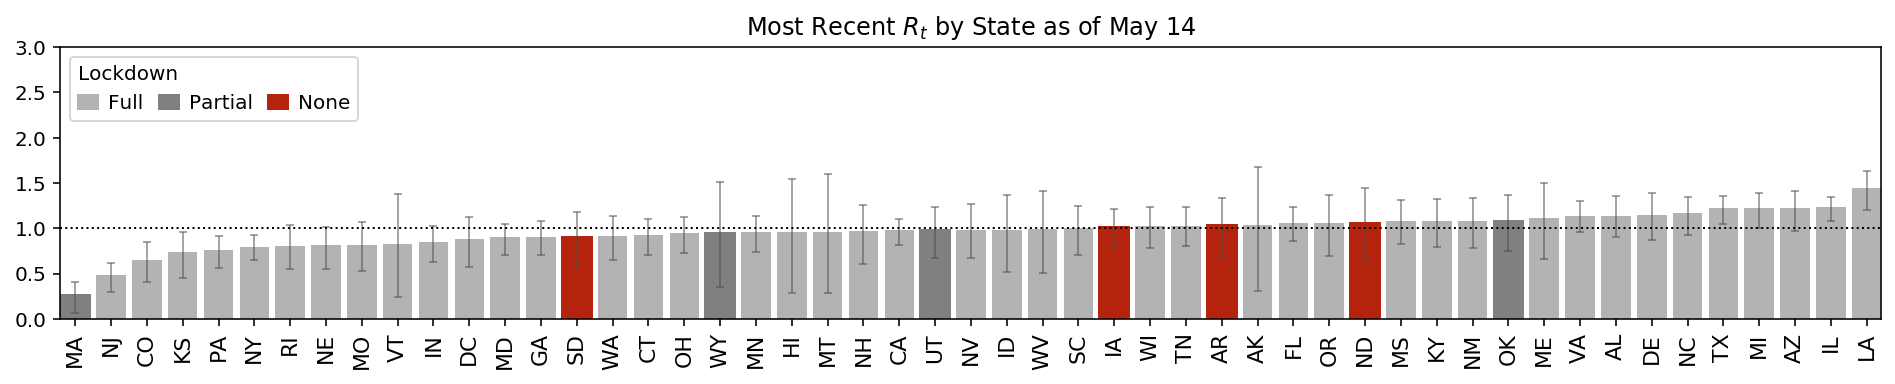

In [26]:

mr.sort_values(['ML', 'High_90'], inplace=True)
fig, ax = plot_standings(mr, title='Most Recent $R_t$ by State as of {}'.format(final_results.index[-1][1].strftime('%B %d')))
save_fig_as_various(fig, 'states_by_ml', verbose=True)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\states_by_high.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\states_by_high.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\states_by_high.svg


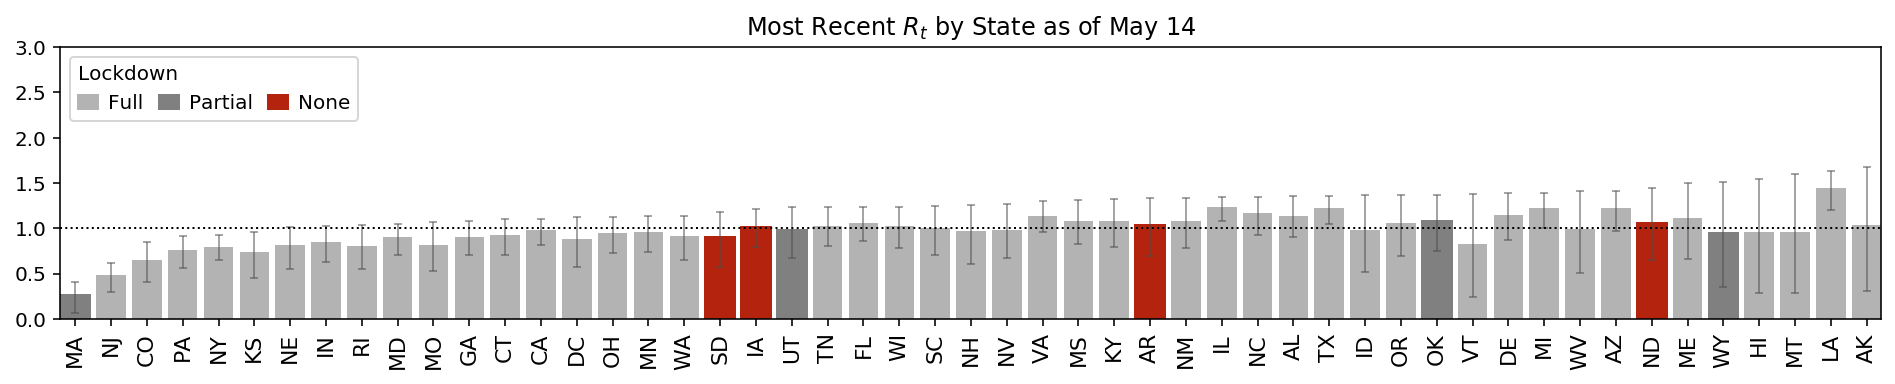

In [27]:

mr.sort_values(['High_90', 'ML'], inplace=True)
fig, ax = plot_standings(mr, title='Most Recent $R_t$ by State as of {}'.format(final_results.index[-1][1].strftime('%B %d')))
save_fig_as_various(fig, 'states_by_high', verbose=True)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\states_by_low.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\states_by_low.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\states_by_low.svg


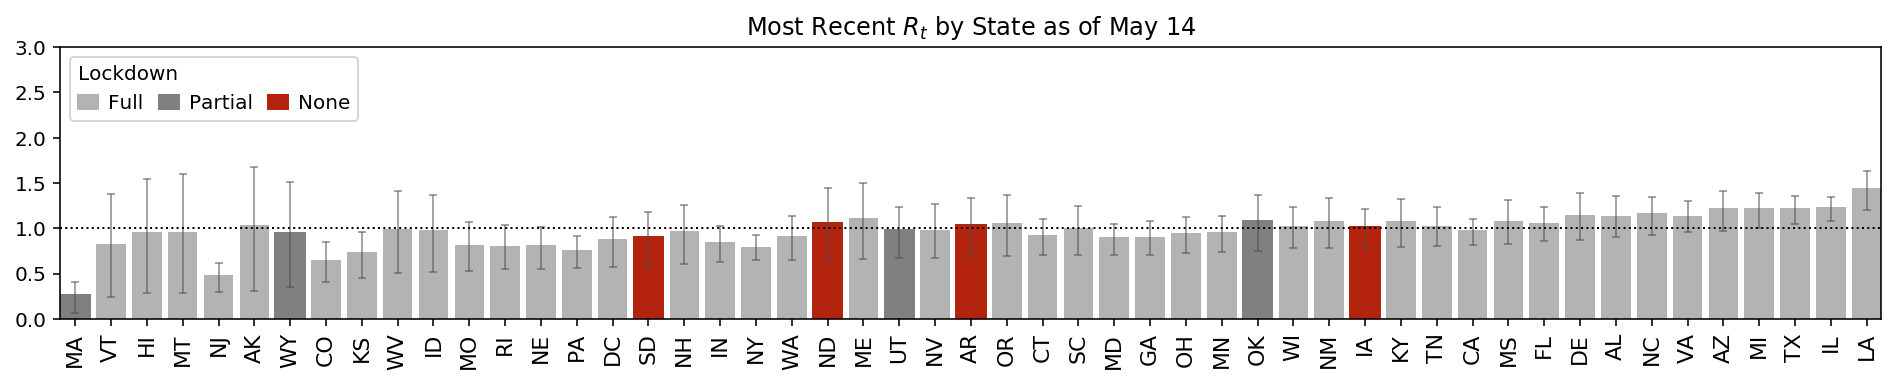

In [28]:

mr.sort_values(['Low_90', 'ML'], inplace=True)
fig, ax = plot_standings(mr, title='Most Recent $R_t$ by State as of {}'.format(final_results.index[-1][1].strftime('%B %d')))
save_fig_as_various(fig, 'states_by_low', verbose=True)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\likely_under_control.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\likely_under_control.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\likely_under_control.svg


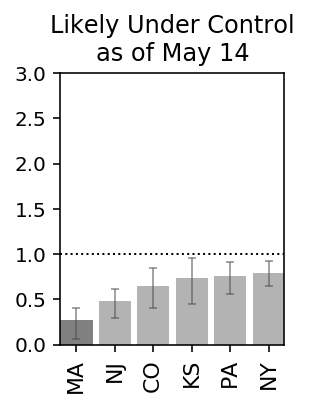

In [24]:

show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control\nas of {}'.format(final_results.index[-1][1].strftime('%B %d')))
ax.get_legend().remove()
save_fig_as_various(fig, 'likely_under_control', verbose=True)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\likely_not_under_control.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\likely_not_under_control.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\likely_not_under_control.svg


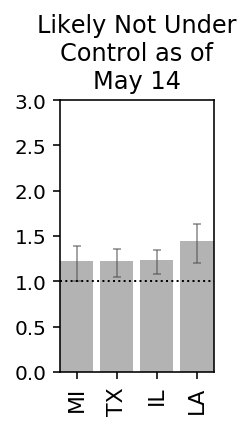

In [25]:

show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under\nControl as of\n{}'.format(final_results.index[-1][1].strftime('%B %d')))
ax.get_legend().remove()
save_fig_as_various(fig, 'likely_not_under_control', verbose=True)